In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from datetime import datetime, timedelta
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.figure_factory as ff
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import calendar

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

## 1. DATA LOADING AND INITIAL EXPLORATION

In [2]:
df = pd.read_csv('D:\sp500-regression\input\clear_sp500.csv')

In [3]:
print(f"Dataset Shape: {df.shape}")
print("Column Information:")
print(df.dtypes)
print("First 5 rows:")
print(df.head())

Dataset Shape: (1614230, 11)
Column Information:
Unnamed: 0        int64
Symbol           object
Date             object
Open            float64
High            float64
Low             float64
Close           float64
Adj Close       float64
Volume            int64
Dividends       float64
Stock Splits    float64
dtype: object
First 5 rows:
   Unnamed: 0 Symbol                       Date       Open       High  \
0           0    MMM  2010-09-07 04:00:00+00:00  69.590302  69.715721   
1           1    MMM  2010-09-08 04:00:00+00:00  68.737457  69.991638   
2           2    MMM  2010-09-09 04:00:00+00:00  70.167221  70.301003   
3           3    MMM  2010-09-10 04:00:00+00:00  69.289299  70.292641   
4           4    MMM  2010-09-13 04:00:00+00:00  70.702339  71.045151   

         Low      Close  Adj Close   Volume  Dividends  Stock Splits  
0  68.578598  68.678932  43.522133  3706643        0.0           0.0  
1  68.737457  69.188965  43.845329  3333252        0.0           0.0  
2  68.9

In [4]:
df = df.drop(df.columns[0], axis=1)

In [5]:
df = df.drop(columns=['Dividends', 'Stock Splits'], axis=1)

In [6]:
df.head()

,Symbol,Date,Open,High,Low,Close,Adj Close,Volume
0,MMM,2010-09-07 04:00:00+00:00,69.590302,69.715721,68.578598,68.678932,43.522133,3706643
1,MMM,2010-09-08 04:00:00+00:00,68.737457,69.991638,68.737457,69.188965,43.845329,3333252
2,MMM,2010-09-09 04:00:00+00:00,70.167221,70.301003,68.963211,69.364548,43.956589,2956153
3,MMM,2010-09-10 04:00:00+00:00,69.289299,70.292641,69.105354,70.183945,44.475872,2590895
4,MMM,2010-09-13 04:00:00+00:00,70.702339,71.045151,70.409698,70.953178,44.963299,3424746


### 1.1 Convert Date column to datetime

In [7]:
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values(['Symbol', 'Date']).reset_index(drop=True)

print(f"Date Range: {df['Date'].min()} to {df['Date'].max()}")
print(f"Number of Stocks: {df['Symbol'].nunique()}")
print(f"Total Records: {len(df)}")

Date Range: 2010-09-07 04:00:00+00:00 to 2025-09-04 04:00:00+00:00
Number of Stocks: 428
Total Records: 1614230


### 1.2 Checking for missing values

In [8]:
print("Missing Values:")
print(df.isnull().sum())

Missing Values:
Symbol       0
Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64


- Không missing/duplicates, giảm risk data leakage

### 1.3 Basic statistics

In [9]:
print("Basic Statistics:")
print(df.describe().T)

Basic Statistics:
               count          mean           std       min           25%  \
Open       1614230.0  1.156536e+02  2.524419e+02  0.246750  3.723000e+01   
High       1614230.0  1.169212e+02  2.554291e+02  0.255500  3.763000e+01   
Low        1614230.0  1.143648e+02  2.495366e+02  0.246250  3.682000e+01   
Close      1614230.0  1.156739e+02  2.525161e+02  0.249750  3.723037e+01   
Adj Close  1614230.0  1.065103e+02  2.518473e+02  0.229005  3.020356e+01   
Volume     1614230.0  6.914894e+06  3.254885e+07  0.000000  1.003800e+06   

                    50%           75%           max  
Open       6.720000e+01  1.225600e+02  9.914170e+03  
High       6.790000e+01  1.238400e+02  9.964770e+03  
Low        6.651000e+01  1.212487e+02  9.794000e+03  
Close      6.722000e+01  1.225700e+02  9.924400e+03  
Adj Close  5.658210e+01  1.106570e+02  9.924400e+03  
Volume     2.172300e+06  4.974800e+06  3.692928e+09  


### *Nhận xét:*
- Dữ liệu lớn (1.6M rows, 428 stocks) bao quát dài hạn (2010-2025), phù hợp cho time series forecasting. 
- Mean Close ~115.67 nhưng std ~252.52 → volatility cao (điển hình S&P 500, đặc biệt post-2020 với COVID/inflation).
- Volume mean ~6.9M nhưng max 3.7B → spikes do earnings/news.

## 2. DATA QUALITY CHECKS

### 2.1 Check for duplicate records

In [10]:
duplicates = df.duplicated(['Symbol', 'Date']).sum()
print(f"Duplicate records: {duplicates}")

Duplicate records: 0


### 2.2 Check for outliers using IQR method

In [11]:
def detect_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    outlier_count = len(outliers)
    total_count = len(df)
    outlier_percentage = (outlier_count / total_count * 100) if total_count > 0 else 0
    
    return outlier_count, outlier_percentage, lower_bound, upper_bound, outliers

price_columns = ['Open', 'High', 'Low', 'Close', 'Adj Close']
print("Outlier Detection:")
for col in price_columns:
    outlier_count, outlier_percentage, lb, ub, outliers_df = detect_outliers(df, col)
    print(f"{col}: {outlier_count} outliers ({outlier_percentage:.2f}% of data, bounds: {lb:.2f} - {ub:.2f})")


Outlier Detection:
Open: 132566 outliers (8.21% of data, bounds: -90.76 - 250.55)
High: 132699 outliers (8.22% of data, bounds: -91.68 - 253.15)
Low: 132490 outliers (8.21% of data, bounds: -89.82 - 247.89)
Close: 132584 outliers (8.21% of data, bounds: -90.78 - 250.58)
Adj Close: 140779 outliers (8.72% of data, bounds: -90.48 - 231.34)


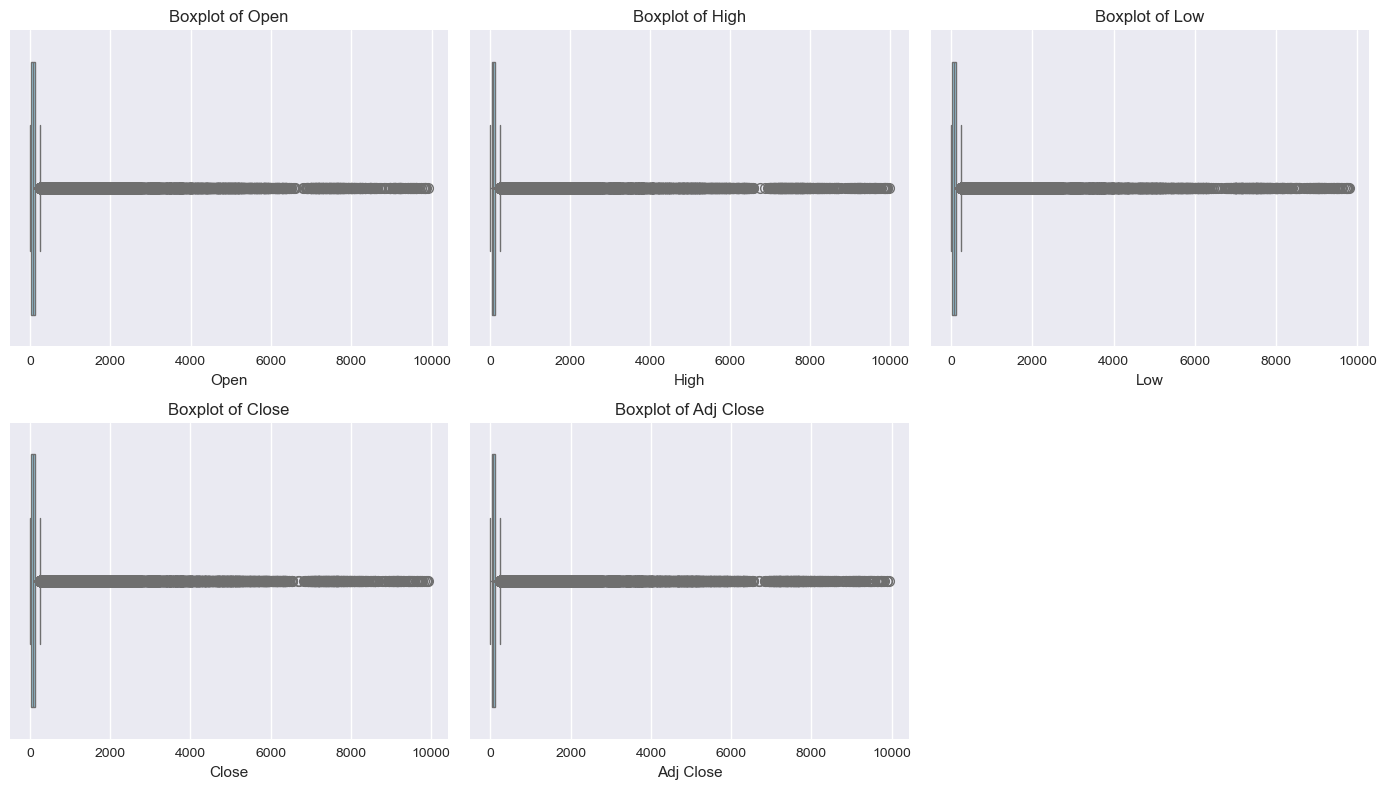

In [12]:
plt.figure(figsize=(14, 8))
for i, col in enumerate(price_columns, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(x=df[col], color='skyblue')
    plt.title(f'Boxplot of {col}')
    plt.xlabel(col)
plt.tight_layout()
plt.show()

### *Nhận xét*: 
- Dữ liệu ngoại lại chiếm xấp xỉ 8%, điều này phản ánh một phần của thị trường tài chính khi biến động liên tục và bất ngờ. Outliers chủ yếu từ crashes (2020 COVID drop) hoặc booms (tech stocks 2021). Nên việc loại bỏ các giá trị ngoại là không hợp lý thay vào đó có thể sử dụng Log-Transform hoặc sử dụng lợi nhuận Log (Log-Return) như đã đề xuất trong tài liệu. 

- Handle Outliers: Áp dụng Winsorizing (cap tại 1-99 percentile) hoặc log transform prices (log(Close) để compress tails). Lý do: Giảm impact crashes mà giữ signals.

In [34]:
from scipy.stats.mstats import winsorize
for col in ['Open', 'High', 'Low', 'Close']:
    df[col] = winsorize(df[col], limits=[0.01, 0.01])  # Cap 1% tails

### 2.3 Check Adjusted Price
**Lý do:** Cột Close là giá đóng cửa thô. Cột Adjusted Close đã được điều chỉnh cho các sự kiện như chia cổ tức, tách/gộp cổ phiếu. Khi phân tích lợi nhuận dài hạn, bắt buộc phải sử dụng Adjusted Close vì nó phản ánh đúng hiệu suất thực tế của khoản đầu tư.
Do đó cũng cần scale lại các features theo tỷ lệ **Adjusted Close / Close**

In [13]:
adj_ratio = df['Adj Close'] / df['Close']
df['Open'] = df['Open'] * adj_ratio
df['High'] = df['High'] * adj_ratio
df['Low'] = df['Low'] * adj_ratio

# Convert "Adj-Close" to "Close" and set "Close" as the label
df.rename(columns={'Adj Close': 'Close_Adj'}, inplace=True)
df.drop('Close', axis=1, inplace=True)
df.rename(columns={'Close_Adj': 'Close'}, inplace=True)

### 2.4 Adding Log-Return
$$
r_{t+1} = \log S_{t+1} - \log S_t
$$

In [14]:
df['Log_Return'] = df.groupby('Symbol')['Close'].transform(lambda x: np.log(x / x.shift(1)))

In [15]:
df = df.drop(df.index[0])

In [16]:
df.head()

,Symbol,Date,Open,High,Low,Close,Volume,Log_Return
1,A,2010-09-08 04:00:00+00:00,18.517940,18.619828,18.333270,18.365110,3923627,-0.005188
2,A,2010-09-09 04:00:00+00:00,18.626193,18.715344,18.416051,18.422419,2937198,0.003116
3,A,2010-09-10 04:00:00+00:00,18.435153,18.581615,18.288691,18.409681,2481031,-0.000692
4,A,2010-09-13 04:00:00+00:00,18.613462,18.759924,18.435159,18.549782,4135424,0.007581
5,A,2010-09-14 04:00:00+00:00,18.479738,18.696247,18.244124,18.575256,3676740,0.001372


In [17]:
df.tail()

,Symbol,Date,Open,High,Low,Close,Volume,Log_Return
1614225,ZBRA,2025-08-28 04:00:00+00:00,323.359985,324.829987,321.910004,322.000000,261800,0.001772
1614226,ZBRA,2025-08-29 04:00:00+00:00,321.660004,321.660004,315.829987,317.089996,440900,-0.015366
1614227,ZBRA,2025-09-02 04:00:00+00:00,310.709991,313.179993,305.429993,307.070007,732000,-0.032110
1614228,ZBRA,2025-09-03 04:00:00+00:00,307.230011,308.350006,303.549988,305.709991,345000,-0.004439
1614229,ZBRA,2025-09-04 04:00:00+00:00,307.000000,309.337494,305.000000,309.130005,116763,0.011125


## 3. FEATURE ENGINEERING

| Feature | Công thức | Ý nghĩa tài chính / kỹ thuật | Tại sao hữu ích cho dự báo giá | Tham số / ngưỡng thường dùng & Ghi chú |
|---|---:|---|---|---|
| Price_Range | `High - Low` | Biên độ dao động trong phiên (volatility intraday) | Cho biết mức biến động/không ổn định trong ngày — có thể liên quan đến risk, breakouts | Không có tham số. Lưu ý: có thể chuẩn hóa theo giá để so sánh giữa mã. |
| Price_Change | `Close - Open` | Hướng và độ lớn biến động phiên | Cho biết bias intraday (bullish/bearish) của phiên hiện tại | Dùng cùng Volume để đánh giá sức mạnh. |
| Price_Change_Pct | `(Close - Open)/Open * 100` | Price_Change chuẩn hóa theo % | So sánh tương đối giữa cổ phiếu có giá khác nhau | Tốt để đưa vào model khi dùng nhiều mã. |
| EMA12 / EMA26 | EWMA của `Close` (span=12,26) | Trung bình lũy thừa ngắn và dài hạn — lọc nhiễu, nhạy với giá gần | Cơ sở cho MACD; giúp phát hiện xu hướng ngắn vs dài hạn | spans: 12, 26 (chuẩn). Tính theo `groupby('Symbol')`. |
| MACD | `EMA12 - EMA26` | Momentum: sự khác biệt giữa trung bình ngắn & dài | Chỉ báo momentum/xu hướng — dấu hiệu bắt đầu/đảo chiều khi cắt Signal | Thường kết hợp với Signal (EMA9) và MACD_hist = MACD - Signal. |
| Signal | EMA9 của MACD | Đường làm mượt MACD để nhận diện crossovers | Crossover giữa MACD và Signal là tín hiệu mua/bán phổ biến | span=9 (chuẩn). Cẩn thận đa cộng tuyến nếu giữ cả EMA12/26. |
| RSI (14) | Chỉ số sức mạnh tương đối (0–100), window=14 | Momentum: mức overbought / oversold | Giúp phát hiện khả năng đảo chiều ngắn hạn (overbought/oversold) | Tham số mặc định 14. Ngưỡng: >70 (overbought), <30 (oversold). |
| CCI (20) | `(TP - SMA(TP))/ (0.015 * mean_dev)` với `TP=(H+L+C)/3`, window=20 | Đo mức lệch giá so với trung bình TP — dùng cho breakout/overbought | Phát hiện breakout & điều kiện quá mua/bán, dùng TP nên bắt dao động H/L/C | window=20 thường dùng. Ngưỡng tham khảo: >100 hoặc <−100. |
| ADX (14) | Average Directional Index (sức mạnh xu hướng), window=14 | Đo "độ mạnh" của xu hướng (không xét hướng) | Phân biệt trend mạnh vs sideway — chọn chiến lược phù hợp | window=14. Ngưỡng: ADX > 20–25 → xu hướng mạnh. Kết hợp +DI/-DI để biết hướng. |


In [18]:
def add_technical_indicators_v2(df):
    df = df.sort_values(['Symbol', 'Date']).copy()

    # Price-based features
    df['Price_Range'] = df['High'] - df['Low']
    df['Price_Change'] = df['Close'] - df['Open']
    df['Price_Change_Pct'] = (df['Close'] - df['Open']) / df['Open'] * 100

    # EMA 12 and 26 for MACD (per Symbol)
    df['EMA12'] = df.groupby('Symbol')['Close'].transform(lambda x: x.ewm(span=12, adjust=False).mean())
    df['EMA26'] = df.groupby('Symbol')['Close'].transform(lambda x: x.ewm(span=26, adjust=False).mean())
    df['MACD'] = df['EMA12'] - df['EMA26']
    df['Signal'] = df.groupby('Symbol')['MACD'].transform(lambda x: x.ewm(span=9, adjust=False).mean())

    # RSI 14 (per Symbol)
    def calc_rsi(series, window=14):
        delta = series.diff()
        gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
        rs = gain / loss
        return 100 - (100 / (1 + rs))
    df['RSI'] = df.groupby('Symbol')['Close'].transform(calc_rsi)

    # CCI 20 (per Symbol) - Using transform method
    def calc_cci_transform(group):
        tp = (group['High'] + group['Low'] + group['Close']) / 3
        sma_tp = tp.rolling(window=20).mean()
        mean_dev = tp.rolling(window=20).apply(lambda x: np.mean(np.abs(x - x.mean())))
        return (tp - sma_tp) / (0.015 * mean_dev)
    
    df['CCI'] = df.groupby('Symbol').apply(calc_cci_transform).droplevel(0)

    # ADX 14 (per Symbol) - Simplified version
    def calc_adx_transform(group):
        high = group['High'].values
        low = group['Low'].values
        close = group['Close'].values
        
        # True Range calculation
        tr = np.maximum(high[1:] - low[1:], 
                       np.maximum(np.abs(high[1:] - close[:-1]), 
                                np.abs(low[1:] - close[:-1])))
        
        # Directional Movement
        plus_dm = np.maximum(high[1:] - high[:-1], 0)
        minus_dm = np.maximum(low[:-1] - low[1:], 0)
        
        # Set DM to 0 if the opposite DM is larger
        plus_dm = np.where(plus_dm > minus_dm, plus_dm, 0)
        minus_dm = np.where(minus_dm > plus_dm, minus_dm, 0)
        
        # Calculate smoothed versions
        window = 14
        atr = pd.Series(tr).ewm(span=window, adjust=False).mean()
        plus_di = 100 * pd.Series(plus_dm).ewm(span=window, adjust=False).mean() / atr
        minus_di = 100 * pd.Series(minus_dm).ewm(span=window, adjust=False).mean() / atr
        
        # DX calculation
        dx = 100 * np.abs(plus_di - minus_di) / (plus_di + minus_di)
        dx = dx.fillna(0)
        
        # ADX
        adx = dx.ewm(span=window, adjust=False).mean()
        
        # Add NaN for first value to match original length
        result = np.full(len(group), np.nan)
        result[1:] = adx
        return pd.Series(result, index=group.index)
    
    df['ADX'] = df.groupby('Symbol').apply(calc_adx_transform).droplevel(0)

    # Drop rows with NaN in technical indicators (but keep Log_Return and Date)
    df = df.dropna(subset=['MACD', 'Signal', 'RSI', 'CCI', 'ADX'])

    # Keep all relevant columns
    keep_cols = [
        'Symbol', 'Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Log_Return',
        'Price_Range', 'Price_Change', 'Price_Change_Pct',
        'MACD', 'Signal', 'RSI', 'CCI', 'ADX'
    ]
    df = df[keep_cols]

    return df

In [19]:
df_features = add_technical_indicators_v2(df)
print(df_features.head())

   Symbol                      Date       Open       High        Low  \
20      A 2010-10-05 04:00:00+00:00  20.982326  21.262515  20.925014   
21      A 2010-10-06 04:00:00+00:00  21.026904  21.090584  20.562047   
22      A 2010-10-07 04:00:00+00:00  20.969600  21.345307  20.912289   
23      A 2010-10-08 04:00:00+00:00  21.147898  21.600020  21.007803   
24      A 2010-10-11 04:00:00+00:00  21.504505  21.631864  21.364410   

        Close   Volume  Log_Return  Price_Range  Price_Change  \
20  21.039637  5904733    0.013713     0.337501      0.057311   
21  20.804028  4522250   -0.011262     0.528537     -0.222877   
22  21.141535  5224606    0.016093     0.433019      0.171935   
23  21.523605  4003033    0.017911     0.592217      0.375708   
24  21.491768  2680246   -0.001480     0.267454     -0.012737   

    Price_Change_Pct      MACD    Signal        RSI         CCI        ADX  
20          0.273138  0.681420  0.549361  74.965557  104.651599  64.564231  
21         -1.059960  

| Feature | Công thức | Ý nghĩa | Tại sao hữu ích cho dự báo | Tham số / Ghi chú |
|---|---|---|---|---|
| Year | `Date.dt.year` | Năm của quan sát | Bắt các trend/chu kỳ dài hạn theo năm (ví dụ thay đổi vĩ mô, regime shifts) | Có thể gây overfit nếu dùng trực tiếp; tốt cho phân tích multi-year. |
| Month | `Date.dt.month` (1–12) | Tháng trong năm | Bắt seasonality theo tháng (ví dụ hiệu ứng tháng đầu/tháng cuối) | Dùng cyclical encoding (`Month_Sin`, `Month_Cos`) nếu cần mô hình học chu kỳ. |
| Quarter | `Date.dt.quarter` (1–4) | Quý tài chính | Bắt hiệu ứng theo quý (báo cáo tài chính, window-dressing) | Có thể one-hot encode nếu muốn. |
| DayOfWeek | `Date.dt.dayofweek` (0=Mon..6=Sun) | Ngày trong tuần | Có nhiều pattern intraday/intraday-to-day: ví dụ thứ Hai/Thứ Sáu khác biệt | Dùng cyclical encoding (`DayOfWeek_Sin/Cos`) cho NN/linear; tree có thể dùng integer/one-hot. |
| DayOfMonth | `Date.dt.day` (1–31) | Ngày trong tháng | Bắt các hiệu ứng ngày cụ thể (ví dụ ngày trả cổ tức, gần cuối tháng) | Có tiếng ồn cao; có thể tạo bucket (early/mid/late month). |
| WeekOfYear | `Date.dt.isocalendar().week` | Tuần trong năm (ISO week) | Bắt seasonality tuần-năm (mùa vụ, kỳ lễ) | Chú ý: ISO week có format khác; tuần 52/53 cần xử lý. |
| IsMonthEnd | `Date.dt.is_month_end.astype(int)` | Cờ 0/1: có phải cuối tháng không | Cuối tháng có thể có rebalancing, window-dressing, chiến lược quỹ | Nếu lịch giao dịch ko hoàn chỉnh (nghỉ lễ), đảm bảo Date là trading date. |
| IsQuarterEnd | `Date.dt.is_quarter_end.astype(int)` | Cờ 0/1: có phải cuối quý không | Cuối quý thường có báo cáo, rebalancing mạnh hơn => tác động giá/volume | Tương tự IsMonthEnd. |
| IsYearEnd | `Date.dt.is_year_end.astype(int)` | Cờ 0/1: có phải cuối năm không | Hiệu ứng cuối năm (tax-loss harvesting, window dressing) | Dùng kết hợp với Year để tránh overfit. |
| Month_Sin / Month_Cos | `sin(2π*Month/12)` / `cos(2π*Month/12)` | Mã hóa chu kỳ tháng — biểu diễn tính tuần hoàn | Giữ tính chu kỳ (tháng 12 và tháng 1 gần nhau) cho NN/linear models | Thường dùng thay cho integer Month; giữ 2 chiều để tránh mất thông tin phase. |
| DayOfWeek_Sin / DayOfWeek_Cos | `sin(2π*DayOfWeek/7)` / `cos(2π*DayOfWeek/7)` | Mã hóa chu kỳ tuần | Giữ tính tuần hoàn (Chủ nhật/Thứ Hai…) cho NN/linear models | Dùng thay cho integer DayOfWeek khi cần. |


In [20]:
# Time-based features
def create_time_features(df):
    """Create time-based features"""
    df['Year'] = df['Date'].dt.year
    df['Month'] = df['Date'].dt.month
    df['Quarter'] = df['Date'].dt.quarter
    df['DayOfWeek'] = df['Date'].dt.dayofweek
    df['DayOfMonth'] = df['Date'].dt.day
    df['WeekOfYear'] = df['Date'].dt.isocalendar().week
    df['IsMonthEnd'] = df['Date'].dt.is_month_end.astype(int)
    df['IsQuarterEnd'] = df['Date'].dt.is_quarter_end.astype(int)
    df['IsYearEnd'] = df['Date'].dt.is_year_end.astype(int)
    
    # Cyclical encoding for seasonal features
    df['Month_Sin'] = np.sin(2 * np.pi * df['Month'] / 12)
    df['Month_Cos'] = np.cos(2 * np.pi * df['Month'] / 12)
    df['DayOfWeek_Sin'] = np.sin(2 * np.pi * df['DayOfWeek'] / 7)
    df['DayOfWeek_Cos'] = np.cos(2 * np.pi * df['DayOfWeek'] / 7)
    
    return df

In [21]:
df_features = create_time_features(df_features)
df_features.head()

,Symbol,Date,Open,High,Low,Close,Volume,Log_Return,Price_Range,Price_Change,...,DayOfWeek,DayOfMonth,WeekOfYear,IsMonthEnd,IsQuarterEnd,IsYearEnd,Month_Sin,Month_Cos,DayOfWeek_Sin,DayOfWeek_Cos
20,A,2010-10-05 04:00:00+00:00,20.982326,21.262515,20.925014,21.039637,5904733,0.013713,0.337501,0.057311,...,1,5,40,0,0,0,-0.866025,0.5,0.781831,0.623490
21,A,2010-10-06 04:00:00+00:00,21.026904,21.090584,20.562047,20.804028,4522250,-0.011262,0.528537,-0.222877,...,2,6,40,0,0,0,-0.866025,0.5,0.974928,-0.222521
22,A,2010-10-07 04:00:00+00:00,20.969600,21.345307,20.912289,21.141535,5224606,0.016093,0.433019,0.171935,...,3,7,40,0,0,0,-0.866025,0.5,0.433884,-0.900969
23,A,2010-10-08 04:00:00+00:00,21.147898,21.600020,21.007803,21.523605,4003033,0.017911,0.592217,0.375708,...,4,8,40,0,0,0,-0.866025,0.5,-0.433884,-0.900969
24,A,2010-10-11 04:00:00+00:00,21.504505,21.631864,21.364410,21.491768,2680246,-0.001480,0.267454,-0.012737,...,0,11,41,0,0,0,-0.866025,0.5,0.000000,1.000000


In [33]:
df_features.describe()

,Open,High,Low,Close,Volume,Log_Return,Price_Range,Price_Change,Price_Change_Pct,MACD,...,DayOfWeek,DayOfMonth,WeekOfYear,IsMonthEnd,IsQuarterEnd,IsYearEnd,Month_Sin,Month_Cos,DayOfWeek_Sin,DayOfWeek_Cos
count,1.605944e+06,1.605944e+06,1.605944e+06,1.605944e+06,1.605944e+06,1.605944e+06,1.605944e+06,1.605944e+06,1.605944e+06,1.605944e+06,...,1.605944e+06,1.605944e+06,1605944.0,1.605944e+06,1.605944e+06,1.605944e+06,1.605944e+06,1.605944e+06,1.605944e+06,1.605944e+06
mean,1.068995e+02,1.080841e+02,1.056958e+02,1.069183e+02,6.898259e+06,5.105797e-04,2.388282e+00,1.880074e-02,3.075757e-02,3.920709e-01,...,2.023194e+00,1.572077e+01,26.581089,3.383680e-02,1.065728e-02,2.663854e-03,-4.339317e-03,-9.502692e-03,3.610531e-01,-9.279940e-02
std,2.523418e+02,2.553331e+02,2.494339e+02,2.524166e+02,3.239713e+07,1.935154e-02,6.863056e+00,4.286691e+00,1.568755e+00,5.108056e+00,...,1.399150e+00,8.753876e+00,14.957621,1.808090e-01,1.026826e-01,5.154376e-02,7.061169e-01,7.080186e-01,5.156351e-01,7.714596e-01
min,2.443637e-01,2.484900e-01,2.379452e-01,2.452808e-01,0.000000e+00,-7.735928e-01,0.000000e+00,-4.273701e+02,-5.007108e+01,-4.220713e+02,...,0.000000e+00,1.000000e+00,1.0,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,-1.000000e+00,-4.338837e-01,-9.009689e-01
25%,3.041379e+01,3.074336e+01,3.008000e+01,3.041608e+01,1.003600e+06,-7.842591e-03,5.174559e-01,-3.800011e-01,-7.311477e-01,-3.053309e-01,...,1.000000e+00,8.000000e+00,14.0,0.000000e+00,0.000000e+00,0.000000e+00,-8.660254e-01,-8.660254e-01,0.000000e+00,-9.009689e-01
50%,5.686000e+01,5.744833e+01,5.627129e+01,5.687513e+01,2.170000e+06,7.612560e-04,1.039955e+00,1.514777e-02,4.086188e-02,1.801282e-01,...,2.000000e+00,1.600000e+01,27.0,0.000000e+00,0.000000e+00,0.000000e+00,-2.449294e-16,-1.836970e-16,4.338837e-01,-2.225209e-01
75%,1.110860e+02,1.122692e+02,1.098851e+02,1.110764e+02,4.967900e+06,9.289532e-03,2.281406e+00,4.278749e-01,8.029596e-01,8.392945e-01,...,3.000000e+00,2.300000e+01,40.0,0.000000e+00,0.000000e+00,0.000000e+00,5.000000e-01,5.000000e-01,7.818315e-01,6.234898e-01
max,9.914170e+03,9.964770e+03,9.794000e+03,9.924400e+03,3.692928e+09,5.572888e-01,7.437998e+02,5.212700e+02,7.658227e+01,2.632760e+02,...,4.000000e+00,3.100000e+01,53.0,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,9.749279e-01,1.000000e+00


## 4. EXPLORATORY DATA ANALYSIS
### 4.1 Price Distribution Analysis

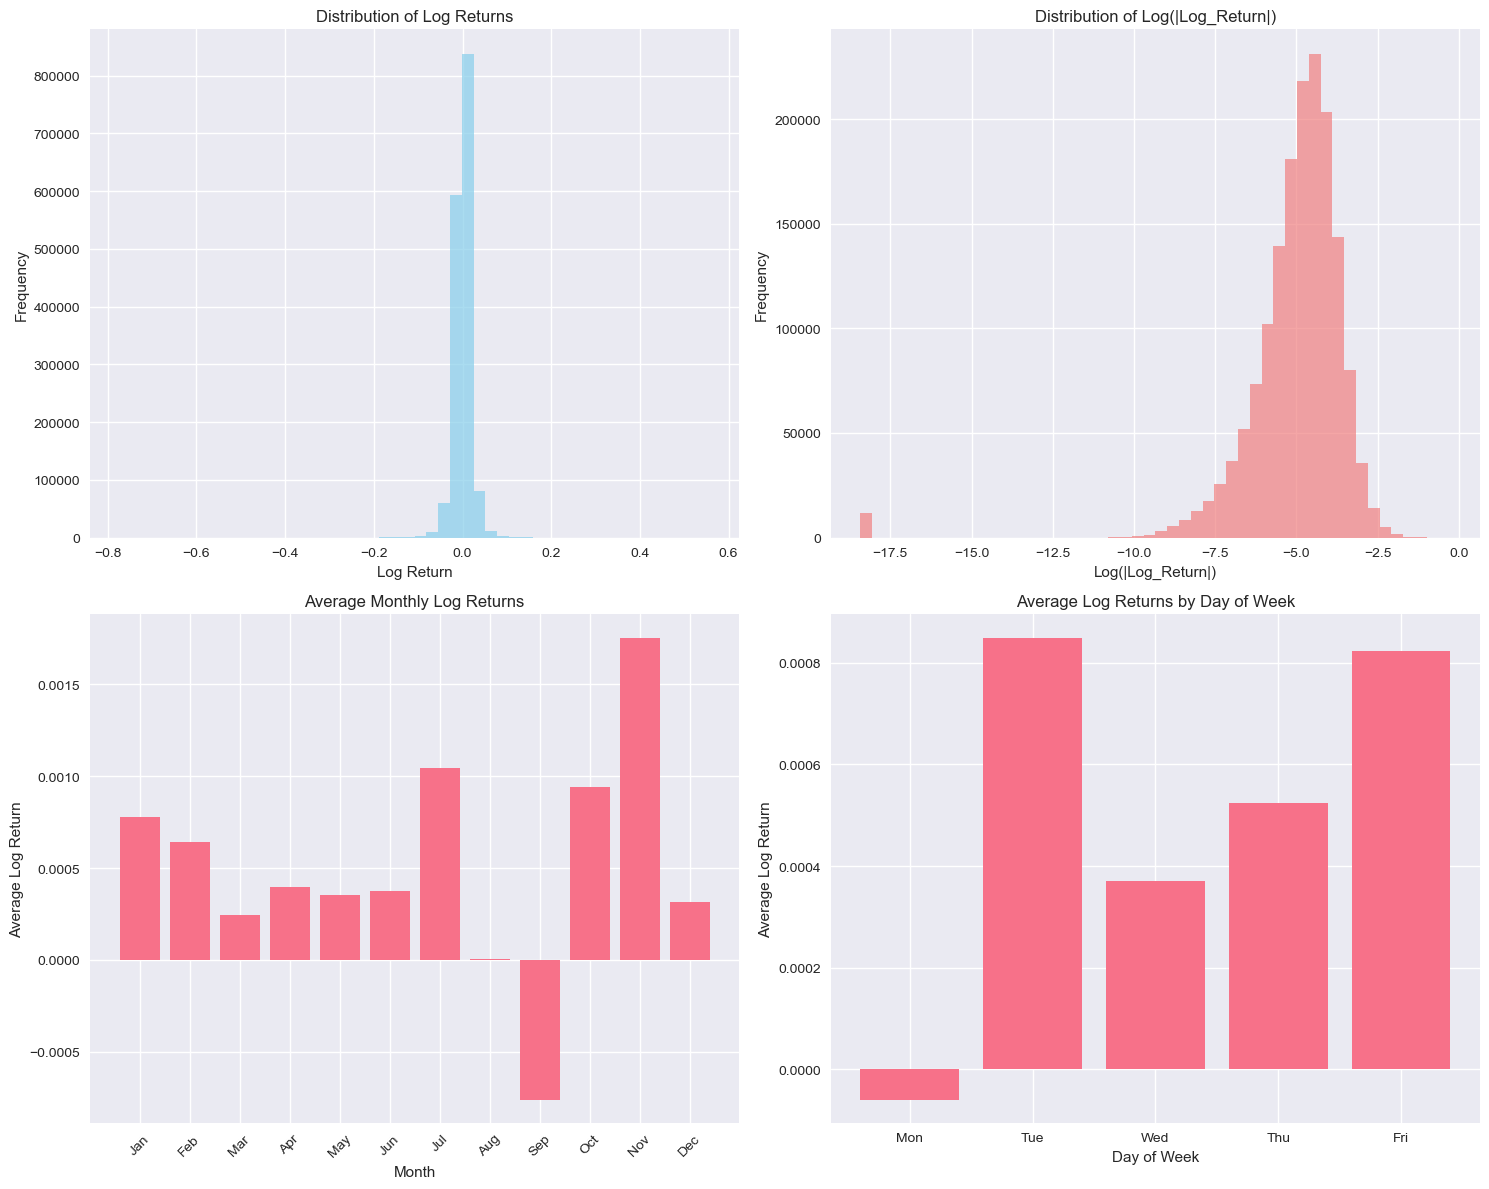

In [22]:
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Log_Return distribution
axes[0,0].hist(df_features['Log_Return'].dropna(), bins=50, alpha=0.7, color='skyblue')
axes[0,0].set_title('Distribution of Log Returns')
axes[0,0].set_xlabel('Log Return')
axes[0,0].set_ylabel('Frequency')

# Log transformation of absolute Log_Returns
log_abs_return = np.log(np.abs(df_features['Log_Return'].dropna()) + 1e-8)
axes[0,1].hist(log_abs_return, bins=50, alpha=0.7, color='lightcoral')
axes[0,1].set_title('Distribution of Log(|Log_Return|)')
axes[0,1].set_xlabel('Log(|Log_Return|)')
axes[0,1].set_ylabel('Frequency')

# Monthly average log returns
monthly_avg = df_features.groupby('Month')['Log_Return'].mean()
months = [calendar.month_abbr[i] for i in range(1, 13)]
axes[1,0].bar(months, monthly_avg.values)
axes[1,0].set_title('Average Monthly Log Returns')
axes[1,0].set_xlabel('Month')
axes[1,0].set_ylabel('Average Log Return')
axes[1,0].tick_params(axis='x', rotation=45)

# Day of week average log returns
dow_avg = df_features.groupby('DayOfWeek')['Log_Return'].mean()
days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
axes[1,1].bar(days[:len(dow_avg)], dow_avg.values)
axes[1,1].set_title('Average Log Returns by Day of Week')
axes[1,1].set_xlabel('Day of Week')
axes[1,1].set_ylabel('Average Log Return')

plt.tight_layout()
plt.show()

### *Nhận xét:*
- Ta thấy phân phối Log-Return tập trung mạnh quanh 0 và khá hẹp, hầu hết các giá trị nằm trong khoảng 0.1 − 0.1. Đỉnh nhọn (leptokurtic distribution)phần lớn lợi nhuận hằng ngày rất nhỏ, gần bằng 0. Đây là hiện tượng điển hình trong dữ liệu tài chính khi lợi nhuận phần lớn rất nhỏ, nhưng đôi khi có các cú sốc lớn gây ra biến động mạnh.
- Tháng 9 có lợi nhuận trung bình âm rõ rệt. Điều này trùng khớp với hiện tượng “September Effect” (lịch sử chứng khoán Mỹ hay giảm mạnh vào tháng 9).
- Tháng 11, 7, 1 có log return trung bình dương cao hơn hẳn. Đây có thể liên quan đến “Santa Rally” (thị trường thường tăng vào cuối năm).
- -> **Điều này cho thấy có yếu tố tính mùa vụ (seasonality) trong lợi nhuận cổ phiếu, cần cân nhắc nếu xây dựng chiến lược giao dịch hoặc mô hình dự báo.**
- Thứ Ba và Thứ Sáu: lợi nhuận trung bình cao nhất.
- Thứ Hai: lợi nhuận gần bằng 0 hoặc hơi âm. Hiện tượng này trong tài chính được gọi là Monday Effect (thị trường có xu hướng giảm đầu tuần).
- Đây là dấu hiệu của anomaly trong tài chính (nghịch lý thị trường), thường thấy trong nghiên cứu về “day-of-week effect”. **Có thể thêm đặc trưng ngày trong tuần khi xây dựng mô hình dự báo.**
- -> **Thử mô hình chuyên biệt cho chuỗi thời gian có volatility clustering (như GARCH, LSTM).**


### 4.2 Time Series Analysis

In [23]:
# Load sector info from CSV
sector_info = pd.read_csv(r'D:\sp500-regression\input\clear_domain.csv', usecols=['Symbol', 'GICS Sector'])

# Merge sector info into df_features
df_features = df_features.merge(sector_info, on='Symbol', how='left')
df_features.rename(columns={'GICS Sector': 'Sector'}, inplace=True)

In [24]:
df_features.head()

,Symbol,Date,Open,High,Low,Close,Volume,Log_Return,Price_Range,Price_Change,...,DayOfMonth,WeekOfYear,IsMonthEnd,IsQuarterEnd,IsYearEnd,Month_Sin,Month_Cos,DayOfWeek_Sin,DayOfWeek_Cos,Sector
0,A,2010-10-05 04:00:00+00:00,20.982326,21.262515,20.925014,21.039637,5904733,0.013713,0.337501,0.057311,...,5,40,0,0,0,-0.866025,0.5,0.781831,0.623490,Health Care
1,A,2010-10-06 04:00:00+00:00,21.026904,21.090584,20.562047,20.804028,4522250,-0.011262,0.528537,-0.222877,...,6,40,0,0,0,-0.866025,0.5,0.974928,-0.222521,Health Care
2,A,2010-10-07 04:00:00+00:00,20.969600,21.345307,20.912289,21.141535,5224606,0.016093,0.433019,0.171935,...,7,40,0,0,0,-0.866025,0.5,0.433884,-0.900969,Health Care
3,A,2010-10-08 04:00:00+00:00,21.147898,21.600020,21.007803,21.523605,4003033,0.017911,0.592217,0.375708,...,8,40,0,0,0,-0.866025,0.5,-0.433884,-0.900969,Health Care
4,A,2010-10-11 04:00:00+00:00,21.504505,21.631864,21.364410,21.491768,2680246,-0.001480,0.267454,-0.012737,...,11,41,0,0,0,-0.866025,0.5,0.000000,1.000000,Health Care


In [25]:
df_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1605944 entries, 0 to 1605943
Data columns (total 30 columns):
 #   Column            Non-Null Count    Dtype              
---  ------            --------------    -----              
 0   Symbol            1605944 non-null  object             
 1   Date              1605944 non-null  datetime64[ns, UTC]
 2   Open              1605944 non-null  float64            
 3   High              1605944 non-null  float64            
 4   Low               1605944 non-null  float64            
 5   Close             1605944 non-null  float64            
 6   Volume            1605944 non-null  int64              
 7   Log_Return        1605944 non-null  float64            
 8   Price_Range       1605944 non-null  float64            
 9   Price_Change      1605944 non-null  float64            
 10  Price_Change_Pct  1605944 non-null  float64            
 11  MACD              1605944 non-null  float64            
 12  Signal            1605944 no

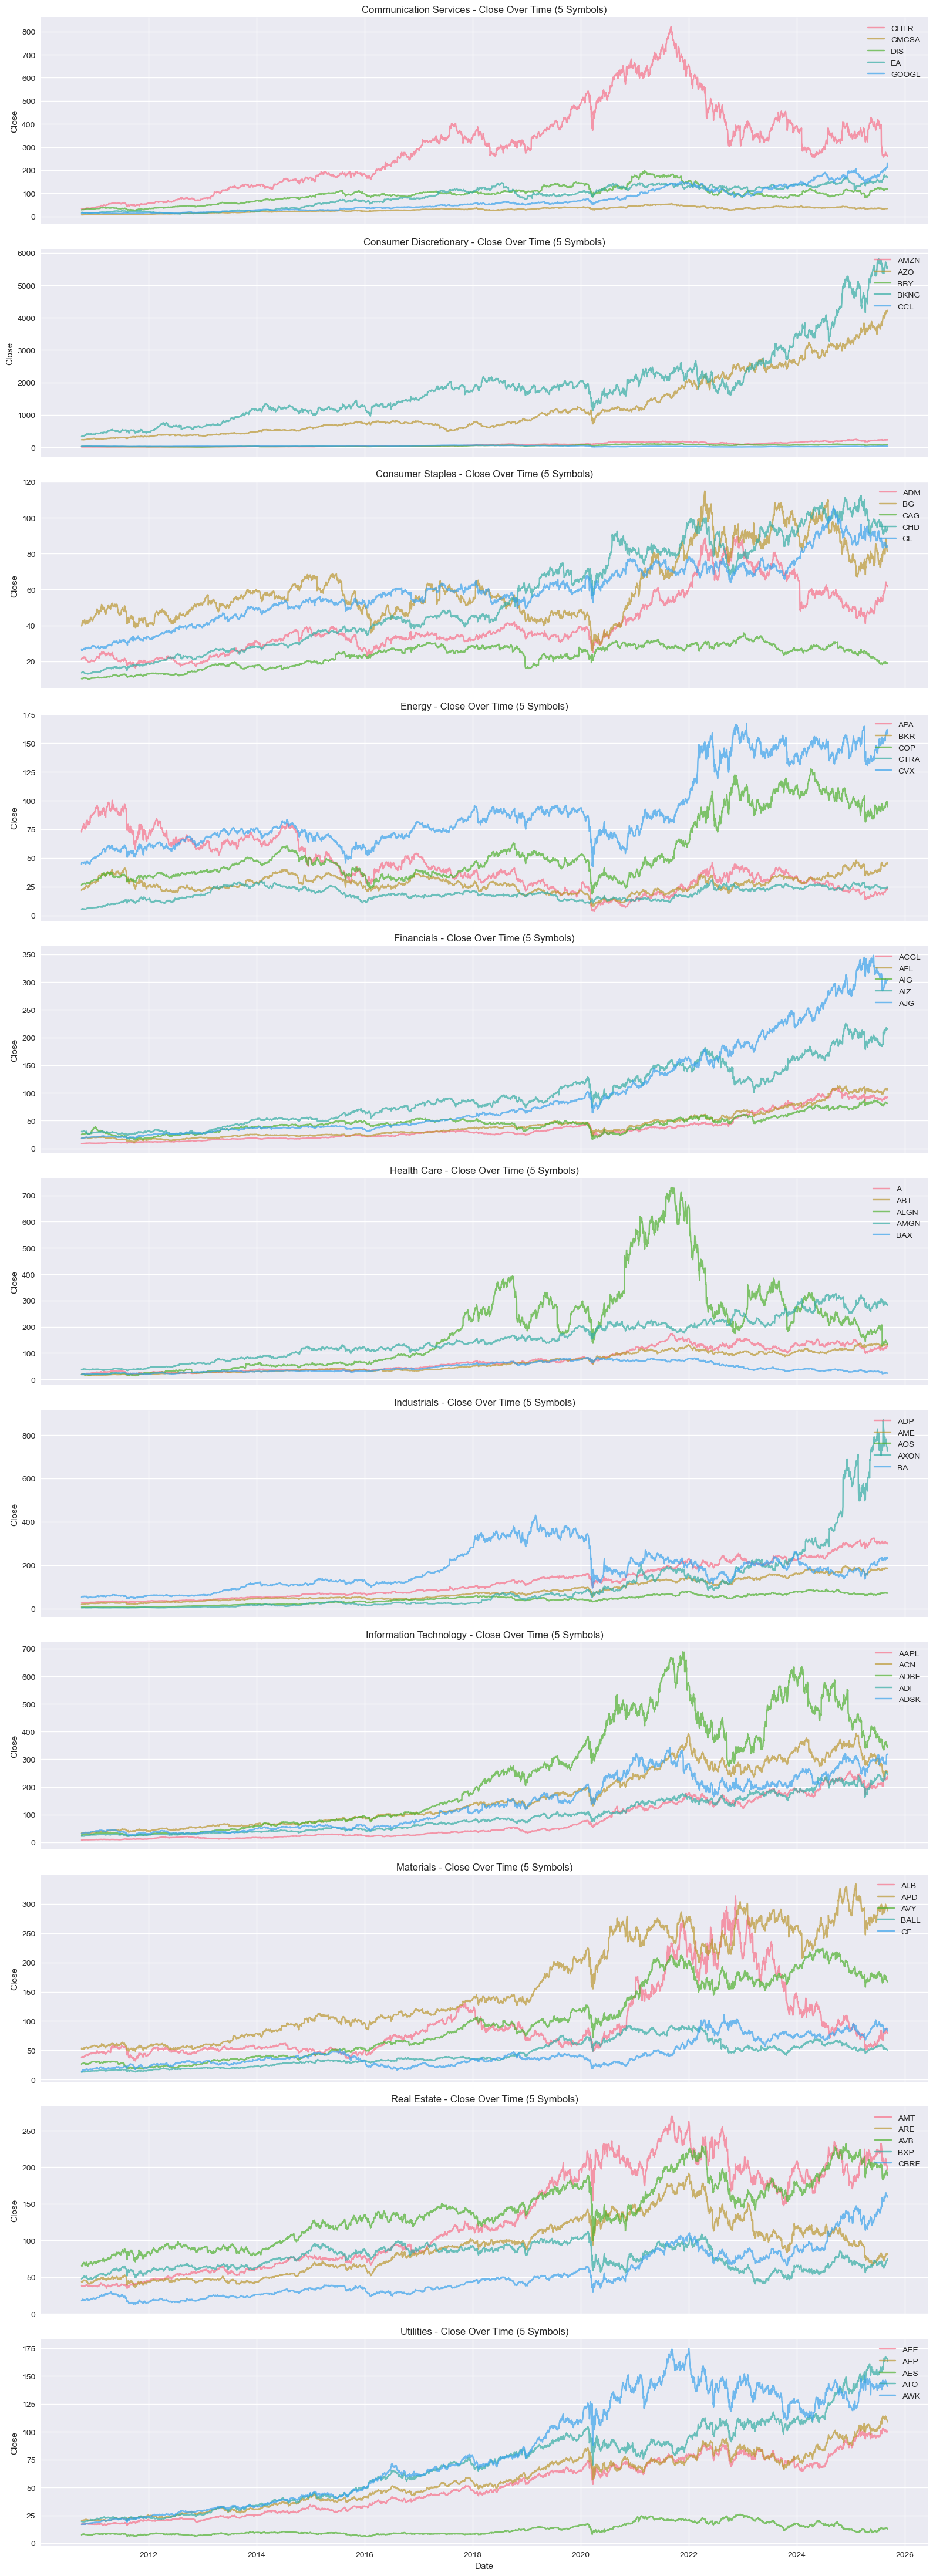

In [26]:
sector_symbols = df_features.groupby('Sector')['Symbol'].unique().apply(lambda x: x[:5])
n_sectors = len(sector_symbols)

fig, axes = plt.subplots(n_sectors, 1, figsize=(16, 4 * n_sectors), sharex=True)

for i, (sector, symbols) in enumerate(sector_symbols.items()):
    ax = axes[i]
    for symbol in symbols:
        data = df_features[df_features['Symbol'] == symbol]
        ax.plot(data['Date'], data['Close'], label=symbol, alpha=0.7)
    ax.set_title(f"{sector} - Close Over Time (5 Symbols)")
    ax.set_ylabel('Close')
    ax.legend(loc='upper right')
    ax.grid(True)

axes[-1].set_xlabel('Date')
plt.tight_layout()
plt.show()


### *Nhận xét:*
- Sự phân hóa trong cùng sector: Không phải cổ phiếu nào cũng có xu hướng giống nhau, ngay cả trong cùng ngành. Vậy nên khi dùng “Sector” làm feature, cần cẩn thận để tránh giả định sai rằng các mã trong ngành đều giống nhau.
- Ngành công nghệ/tiêu dùng (Communication Services, Consumer Discretionary) có tăng trưởng dài hạn mạnh, nhưng có sự khác biệt lớn giữa “winners” (GOOGL, AMZN, BKNG) và “laggards” (CCL, BBY).
- Ngành phòng thủ (Consumer Staples) ít biến động, tăng đều, phù hợp để làm chuẩn so sánh.
- Ngành năng lượng (Energy) rất nhạy cảm với biến động vĩ mô và hàng hóa, có tính chu kỳ mạnh.
- -> **Có thể phân cụm cổ phiếu trong từng sector để xem “leader” và “follower”, từ đó giúp dự báo tốt hơn.**

## 6. CORRELATION ANALYSIS

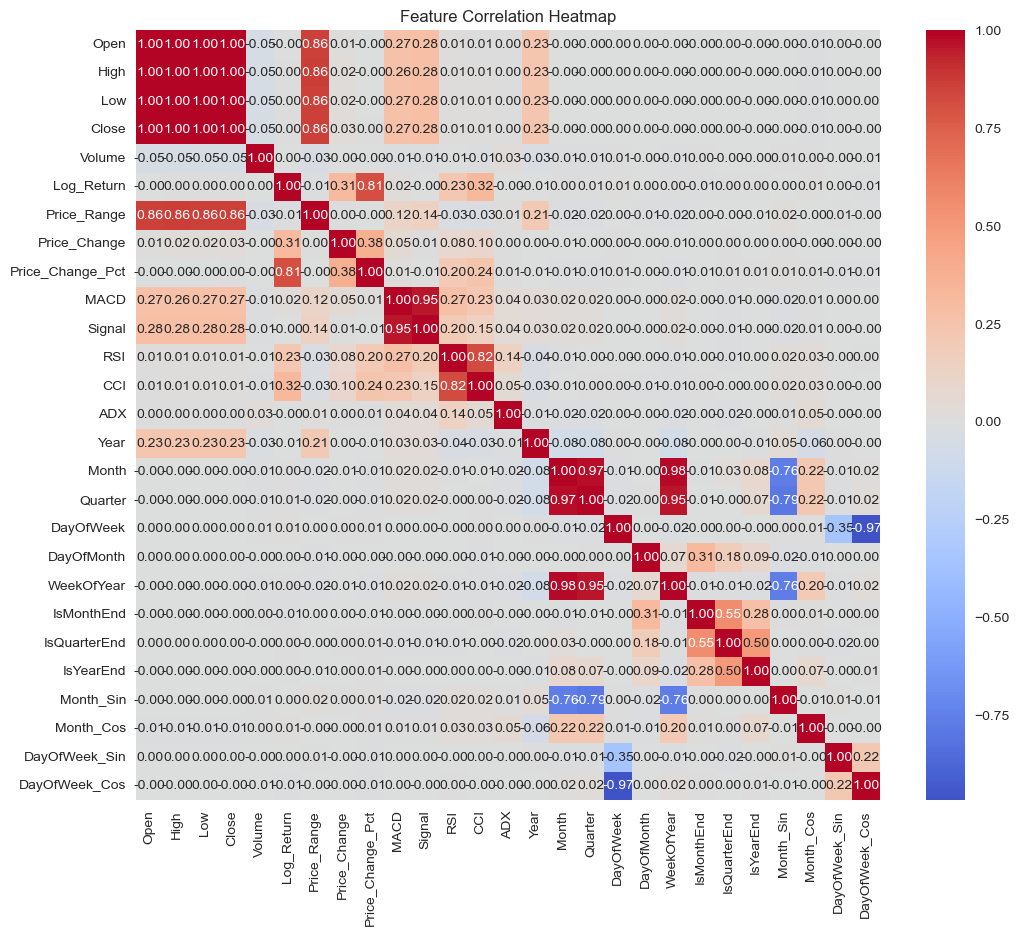

In [28]:
numeric_features = df_features.select_dtypes(include=[np.number]).dropna()
corr_matrix = numeric_features.corr()

# Heatmap of feature correlations
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title('Feature Correlation Heatmap')
plt.show()


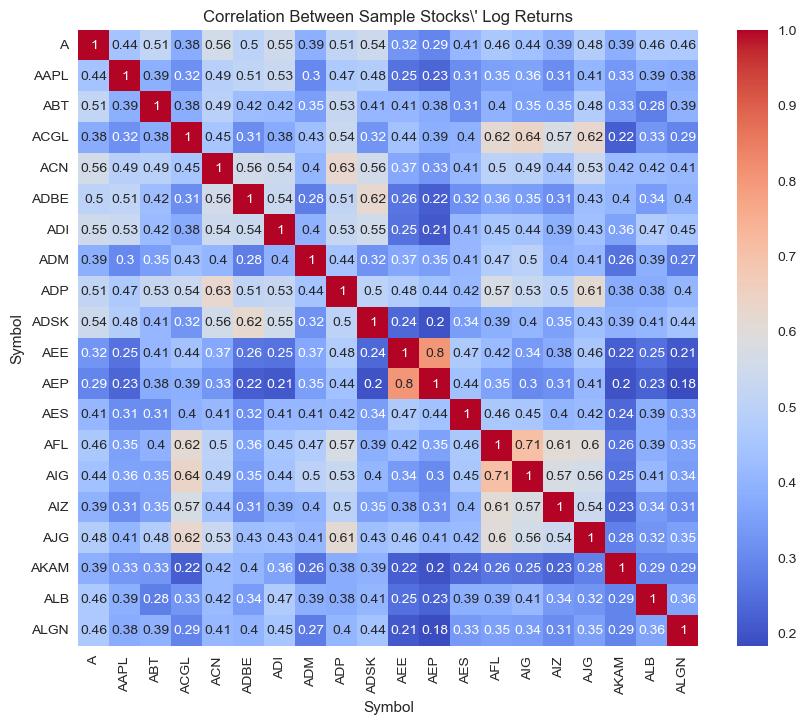

In [29]:
# Correlation between sample stocks' returns (pivot returns)
returns_pivot = df_features.pivot(index='Date', columns='Symbol', values='Log_Return').dropna()
stock_corr = returns_pivot.corr()

# Heatmap for sample stocks (limit to 20 for readability)
sample_corr = stock_corr.iloc[:20, :20]
plt.figure(figsize=(10, 8))
sns.heatmap(sample_corr, annot=True, cmap='coolwarm')
plt.title("Correlation Between Sample Stocks\\' Log Returns")
plt.show()

## 8. FEATURES IMPORTANT ANALYSIS

### 8.1 Random Forest Feature Importance

In [30]:
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.preprocessing import StandardScaler
# import matplotlib.pyplot as plt

# def rf_feature_importance(df, target='Log_Return', n_estimators=100):
#     # Prepare features (exclude non-numeric and target columns)
#     feature_cols = df.select_dtypes(include=[np.number]).columns.tolist()
#     feature_cols.remove(target)
    
#     # Scale features
#     scaler = StandardScaler()
#     X = scaler.fit_transform(df[feature_cols])
#     y = df[target]
    
#     # Train Random Forest
#     rf = RandomForestRegressor(n_estimators=n_estimators, random_state=42)
#     rf.fit(X, y)
    
#     # Get feature importance
#     importance = pd.DataFrame({
#         'feature': feature_cols,
#         'importance': rf.feature_importances_
#     }).sort_values('importance', ascending=False)
    
#     # Plot
#     plt.figure(figsize=(12, 6))
#     plt.bar(importance['feature'][:10], importance['importance'][:10])
#     plt.xticks(rotation=45)
#     plt.title('Top 10 Most Important Features (Random Forest)')
#     plt.tight_layout()
#     plt.show()
    
#     return importance

# importance_df = rf_feature_importance(df_features)
# print(importance_df)

### 8.2 SHAP Feature Importance

In [31]:
import numpy as np
import pandas as pd
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
import xgboost  as xgb
import shap
from sklearn.inspection import permutation_importance
# from concrete.ml.sklearn import XG
exclude_cols = ["Log_Return", "Date", "Symbol", "Sector"]

# Select all columns except the excluded ones
feature_cols = [col for col in df_features.columns if col not in exclude_cols]

# X, y
X = df_features[feature_cols]  # list các feature
y = df_features['Log_Return']

# TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

# Train XGBoost baseline on last split
train_idx, val_idx = list(tscv.split(X))[-1]
X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

model = xgb.XGBRFRegressor(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)
model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)

# Baseline metric
pred = model.predict(X_val)
print("Val RMSE:", np.sqrt(mean_squared_error(y_val, pred)))

# 1) XGBoost built-in importance
imp_gain = model.get_booster().get_score(importance_type='gain')
imp_gain = pd.Series(imp_gain).sort_values(ascending=False)

# 2) SHAP (TreeExplainer)
explainer = shap.TreeExplainer(model)
# nếu dataset lớn: sample
X_shap = X_val.sample(n=min(2000, len(X_val)), random_state=42)
shap_values = explainer.shap_values(X_shap)
mean_abs_shap = np.abs(shap_values).mean(axis=0)
shap_importance = pd.Series(mean_abs_shap, index=X_shap.columns).sort_values(ascending=False)

# 3) Permutation importance (on validation set)
perm = permutation_importance(model, X_val, y_val, n_repeats=10, random_state=42, scoring='neg_mean_squared_error')
perm_importance = pd.Series(np.sqrt(-perm.importances_mean), index=X_val.columns).sort_values()

# Summarize
summary = pd.DataFrame({
    'xgb_gain': imp_gain,
    'shap_mean_abs': shap_importance,
    'perm_rMSE_increase': perm_importance  # lower means less hurt; careful: sorting sign
}).fillna(0)
print(summary.head(30))

# Select top-k by shap (example k=20)
top_k = shap_importance.head(20).index.tolist()
X_train_k, X_val_k = X_train[top_k], X_val[top_k]

# Retrain on selected features and compare
model_k = xgb.XGBRegressor(**model.get_params())
model_k.fit(X_train_k, y_train, eval_set=[(X_val_k, y_val)], verbose=False)
pred_k = model_k.predict(X_val_k)
print("Val RMSE with top-k:", np.sqrt(mean_squared_error(y_val, pred_k)))


Val RMSE: 0.01961588495086397
                  xgb_gain  shap_mean_abs  perm_rMSE_increase
ADX               0.322813   1.684144e-06            0.000000
CCI               0.684844   3.619335e-05            0.000000
Close             0.993409   8.955738e-06            0.000428
DayOfMonth        0.281657   6.540666e-08            0.000000
DayOfWeek         0.138279   6.621755e-08            0.000000
DayOfWeek_Cos     0.058773   2.215089e-08            0.000000
DayOfWeek_Sin     0.071817   8.598573e-08            0.000000
High              0.427146   1.034078e-06            0.000096
IsMonthEnd        0.011793   2.261892e-10            0.000000
IsQuarterEnd      0.000000   0.000000e+00           -0.000000
IsYearEnd         0.000000   0.000000e+00           -0.000000
Low               1.426374   1.321178e-05            0.001191
MACD              0.348488   4.273507e-06            0.000000
Month             0.064803   4.705531e-08            0.000000
Month_Cos         0.043027   2.505617e-0

### *Nhận xét:*
- Từ kết quả của SHAP cho thấy: Price_Change (change abs, gain 8.44), Price_Change_Pct (% change), Low/Open/Close (price levels). Temporal (DayOfMonth, Month) ít quan trọng (gain <0.3). Permutation: Low quan trọng nhất (tăng RMSE 0.0012 khi shuffle) cho thấy low price signal downside risk.
- Mutual Info (tương tự SHAP): Xác nhận price-derived features quan trọng nhất (MI cao cho changes), indicators như RSI/MACD trung bình, date features thấp cho thấy cyclical encoding chưa hiệu quả lắm.
- Price changes dominate vì chúng trực tiếp liên quan target (Log_Return). SHAP mean_abs thấp (~1e-4) cho thấy features weakly predictive (stock market semi-efficient, hard to beat). 
- Cải thiện 47% RMSE với top-20 cho thấy feature selection hiệu quả, giảm noise. Trong tài chính, điều này gợi ý focus momentum strategies (dựa Price_Change) hơn calendar effects.
- Dữ liệu chất lượng cao nhưng noisy/volatility-driven. Predictability moderate (RMSE ~1-2%), phù hợp short-term forecast (1-5 days). Market efficiency cao vậy nên cần external data để boost.

### 8.3 Mutual Information Score

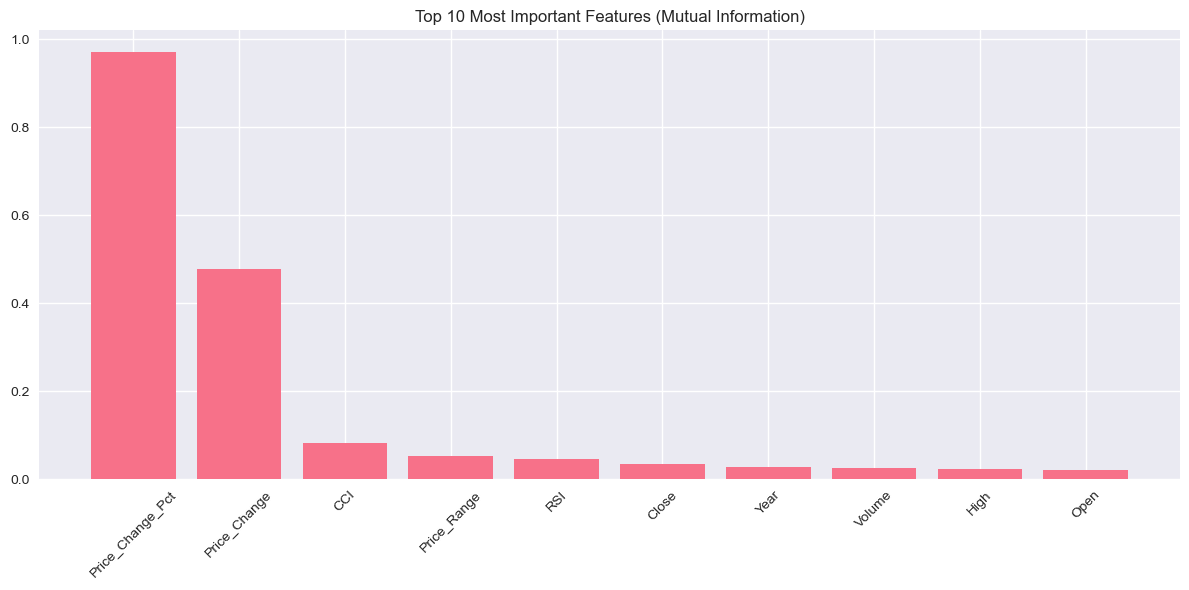

             feature  importance
7   Price_Change_Pct    0.971787
6       Price_Change    0.478311
11               CCI    0.082166
5        Price_Range    0.052882
10               RSI    0.045882
3              Close    0.033884
13              Year    0.027771
4             Volume    0.025589
1               High    0.023349
0               Open    0.022164
2                Low    0.022046
8               MACD    0.016104
9             Signal    0.014388
18        WeekOfYear    0.010318
17        DayOfMonth    0.004444
14             Month    0.003907
12               ADX    0.003820
15           Quarter    0.002168
23         Month_Cos    0.002010
22         Month_Sin    0.001938
25     DayOfWeek_Cos    0.000220
21         IsYearEnd    0.000168
24     DayOfWeek_Sin    0.000167
20      IsQuarterEnd    0.000123
19        IsMonthEnd    0.000112
16         DayOfWeek    0.000106


In [32]:
from sklearn.feature_selection import mutual_info_regression

def mutual_info_importance(df, target='Log_Return'):
    # Prepare features
    feature_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    feature_cols.remove(target)
    
    # Calculate mutual information
    mi_scores = mutual_info_regression(df[feature_cols], df[target])
    
    # Create importance DataFrame
    importance = pd.DataFrame({
        'feature': feature_cols,
        'importance': mi_scores
    }).sort_values('importance', ascending=False)
    
    # Plot
    plt.figure(figsize=(12, 6))
    plt.bar(importance['feature'][:10], importance['importance'][:10])
    plt.xticks(rotation=45)
    plt.title('Top 10 Most Important Features (Mutual Information)')
    plt.tight_layout()
    plt.show()
    
    return importance
importance_df = mutual_info_importance(df_features)
print(importance_df)